# Discrete-time quantum walk on a line graph

## Introduction
The discrete-time quantum walk is a quantum analog of the discrete-time random walk on a graph $G = (V,E)$. In a random walk, at each time step, we move to a node of the graph $G$, and the decision of where to move is governed by a probabilistic rule. The simplest rule is when, at each step, we move from one vertex to each of its neighbors with equal probability. Therefore in this simplest rule, the walk is governed by the $|V| \times |V| $ matrix $M$ with $$ M_{jk} = \begin{cases} 1/\text{deg}(k) & \text{ if } (j,k) \in E \\
0 & \text{ otherwise} \end{cases}. $$ 

In this notebook, we implement the discrete-time quantum walk on a line graph with 16 nodes, where we move from one vertex to each of its neighbors with equal probability. Therefore, the walk is governed by the $16 \times 16 $ matrix $M$ with $$ M_{jk} = \begin{cases} 1 & \text{ if } (j,k) = (0,1) \text{ or } (15,14) \\
0.5 & \text{ if } 0< j < 15 \text{ and } k \in \{j-1,j+1\} \\
0 & \text{ otherwise} \end{cases}. $$ 

## Defining the quantum walk
The Hilbert space of the quantum walk is generated by the states of the form $\ket{j,k}$ where $j,k \in V$. The state of the form $\ket{j,k}$ where $(j,k)\in E$ represents a walker at vertex $j$ that will move toward the vertex $k$. The process consists of two operators:

 
1. Coin Flip Operator (the `C_operator` in the code): updates the probabilities of the next move. This operator is given by $$ C = 
    \sum_{j \in V} \ket{j}\bra{j} \otimes (2\ket{\delta_j}\bra{\delta_j}  - I), $$ where $\ket{\delta_j} = \frac{1}{\sqrt{\text{deg}(j)}} \sum_{k : (j,k)\in E} \ket{k}$. 

2. Shift Operator (the `S_operator` in the code): actually moves the walker. This is implemented by swapping the two registers and is given by the operator 
$$ S = \sum_{(j,k) \in E} \ket{j,k}\bra{k,j}$$


Reference: Andrew M. Childs, Lecture Notes on Quantum Algorithms, url: https://www.cs.umd.edu/~amchilds/qa/qa.pdf

In [1]:
from classiq import *

As we have 16 vertices in our line graph, we need 4 qubits to represent those 16 vertices.

In [2]:
num_qubits = 4      #number of qubits needed to represent the vertices
num_vertices = 2**num_qubits    #number of vertices in the our line graph

## Implementing the Coin Flip operator

In [3]:
@qfunc
def prepare_minus(x: QBit):
  """ Prepares |-> state in the input qubit
  
  Args:
    x (QBit): the input state
  """
  X(x)
  H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  """ 
  Computes the function for the Grover Zero Diffuser operator 
  
  Args:
      aux (Output[QNum]): Ancilla qubit for Phase-Kickback
      x (QNum): the current vertex to check and mark
      """
  aux ^= (x!=0)

@qfunc
def zero_diffuzer(x: QNum):
  """ 
  Implements the Grover Zero Diffuser operator  """

  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
  

def C_iteration(i: CInt,vertices: QNum, adjacent_vertices:QNum):
  """ 
  Applies the coin flip to the vertex i

  Args:
    i (CInt): the vertex where to apply 
    vertices (QNum): QNum representing the vertices
    adjacent_vertices (QNum): QNum reperesenting the edges 
     """
  prob = [0]*num_vertices
  if i == 0:              # (0,1) entry of M
      prob[i+1] = 1
  elif i == 15:           # (15,14) entry of M
      prob[i-1] = 1
  else:                   # (j,j-1) and (j,j+1) entry of M when 0<j<15
      prob[i+1]=0.5
      prob[i-1]=0.5
  print(f'State={i}, prob vec ={prob}')
  
  control(ctrl=vertices==i,
      operand=lambda: within_apply(
          compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
          action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
  """ 
  Applies the coin flip to all the vertices

  Args: 
    vertices (QNum): QNum representing the vertices
    adjacent_vertices (QNum): QNum reperesenting the adjacent vertices 
     """  
  for i in range(2**num_qubits):
    C_iteration(i,vertices,adjacent_vertices)

## Implementing the Shift Operator:

In [4]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """ 
    Checks if (vertices,adjacent_vertices) is in the edge set E
      
    Args:
        res (Output[QBit]): Stores 1 if they are adjacent.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.    
        """
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """ 
    Swaps the QAarrays x and y

    Args:
        x (QArray): first QArray to swap
        y (QArray): second QArray to swap 
     """
    repeat(count= x.len,
        iteration= lambda i: SWAP(x[i],y[i]))


@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """ 
    Applies the Shift operator

    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices. 
       """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

## Synthesize the circuit

In [5]:

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """ 
    The main function to create the qmod
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.  """ 
    allocate(num_qubits,vertices)       #allocate qubits for vertices
    hadamard_transform(vertices)        #applies Hadamard gates to the vertices register to initialize superposition
    allocate(num_qubits,adjacent_vertices) #allocate qubits for adjacent vertices

    C_operator(vertices,adjacent_vertices)      #applies Coin Flip
    S_operator(vertices,adjacent_vertices)      #applies Shift

qmod = create_model(main)       #create the qmod
qprog = synthesize(qmod)        #synthesize the circuit

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

In [6]:
# visualize the circuit
show(qprog)

Opening: https://platform.classiq.io/circuit/0d5c7e96-de0e-4356-8802-c9cfca715558?version=0.43.3


Here is the full circuit.

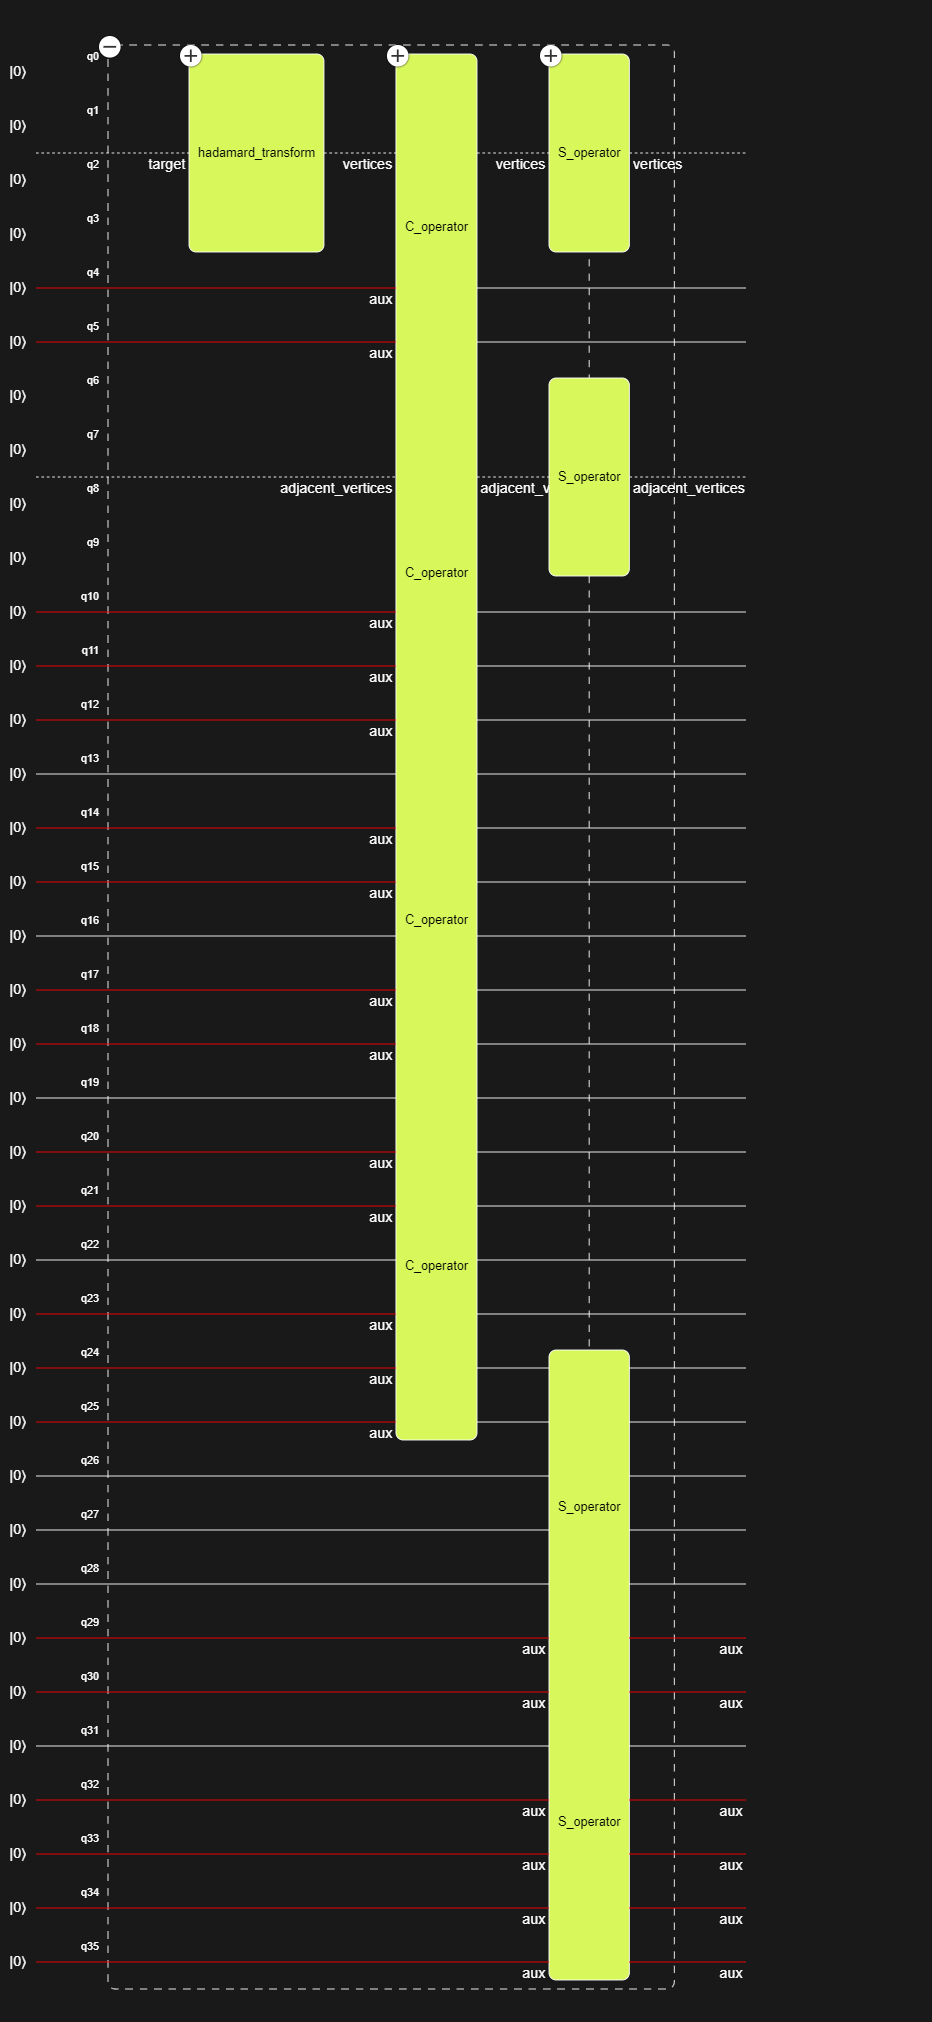

The circuit begins with Hadamard gates into the `vertices` register, creating an equal superposition across all possible states, giving the walker a chance to be at any of the 16 nodes. The Coin Flip operator and the Shit operators are subsequently applied.

## Zooming into parts of the `C_operator`

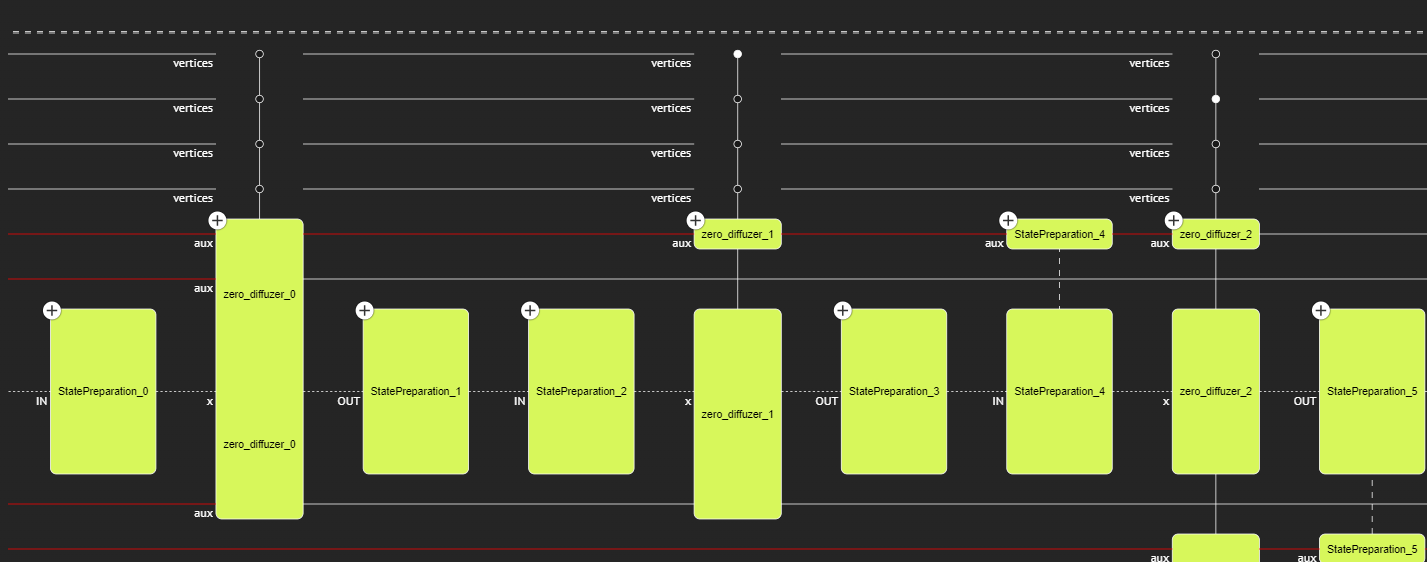